In [217]:
#######Manipulação de dados e operações matemáticas
import pandas as pd
import numpy as np
import array
#######Padronização de respostas rest
import json
import mysql.connector
#######Api de consulta de CriptoMoedas e Índices 
import yfinance as yf
from mercado_bitcoin import DataAPI
#######Tratamento de dados temporais
import datetime as dt
########Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
import os
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.widgets import Dropdown
from bokeh.io import curdoc, push_notebook, show, output_notebook
from bokeh.layouts import column, row
from bokeh.models import BooleanFilter, CDSView, Select, Range1d, HoverTool
from bokeh.palettes import Category20
from bokeh.models.formatters import NumeralTickFormatter
########
from sklearn.preprocessing import StandardScaler

In [208]:
###Conexão à base de dados
def getConnection():
    my_db = mysql.connector.connect(
      host="localhost",
      user="root",
      password="root",
      database="coindb",
      port="8889"
    )
    return my_db

###Classe para padronização dos objetos manipulados
class Sumary():
    def __init__(self, coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price):
        self.coin = coin
        self.date = date
        self.opening = opening
        self.closing = closing
        self.lowest = lowest
        self.highest = highest
        self.volume = volume
        self.quantity = quantity
        self.amount = amount
        self.avg_price = avg_price

###Criação padronizada de tabelas
def create_table(coin_name):
    print()
    command = f"CREATE TABLE {coin_name}_day_sumary (id int(11) NOT NULL PRIMARY KEY AUTO_INCREMENT, coin varchar(5) NOT NULL, date date NOT NULL, opening double NOT NULL, closing double NOT NULL, lowest double NOT NULL, highest double NOT NULL, volume double NOT NULL, quantity double NOT NULL, amount double NOT NULL, avg_price double NOT NULL)"
    cnn = getConnection()
    cnn.cursor().execute(f"drop table if exists {coin_name}_day_sumary;")
    cnn.commit()
    cnn.cursor().execute(command)
    cnn.commit()

###Solicita uma lista de papéis ou índices com base em uma data inicial até os dias de hoje
def getStock(stock_array, date_init):
    bag_amount = 20
    bag_control = 0
    date_now = dt.date.today()
    for stock in stock_array:
        bag_control = 0
        cnn = getConnection()
        create_table(stock)
        tickerData = yf.Ticker(stock)
        tickerDf = pd.DataFrame(tickerData.history(start=date_init.strftime("%Y-%m-%d"), end=date_now.strftime("%Y-%m-%d")))
       
        for index, stk in tickerDf.iterrows():
           
            try:
                command = f"INSERT INTO {stock}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{stock}', '{index}', '{stk.Open}', '{stk.Close}', '{stk.Low}', '{stk.High}', '{stk.Volume}', '0', '0', '0')"
                print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
                    #print(calc_date)
            except Exception as e:
                print(e)
                continue
        cnn.commit()
    cnn.commit()

#Solicita o histórico de negociações de uma lista de cryptomoedas com base em uma data inicial    
def getCripto(coin_array, date_init):
    print("Dentro do Cripto")
    cnn = getConnection()
    date_now = dt.date.today()
    print("Calculando a data")
    for coin in coin_array:
        create_table(coin)
        calc_date = date_init
        bag_amount = 20
        bag_control = 0
        #Descomentar se desejar excluir todos os dados anteriores
        #command = f"delete from {coin}_day_sumary"
        #cnn.cursor().execute(command)
        #cnn.commit()
        while calc_date.date() < date_now:
            bag_control += 1
            calc_date += dt.timedelta(days=1)
            if(calc_date.weekday() > 5):
                continue
            sumary_json = DataAPI.day_summary(coin, calc_date.year, calc_date.month, calc_date.day).json()
            sumary_json["coin"] = coin
            try:
                sumary = Sumary(**sumary_json)
                command = f"INSERT INTO {coin}_day_sumary (coin, date, opening, closing, lowest, highest, volume, quantity, amount, avg_price) values ('{sumary.coin}', '{sumary.date}', '{sumary.opening}', '{sumary.closing}', '{sumary.lowest}', '{sumary.highest}', '{sumary.volume}', '{sumary.quantity}', '{sumary.amount}', '{sumary.avg_price}')"
                #print(command)
                cnn.cursor().execute(command)
                if (bag_control >= bag_amount):
                    cnn.commit()
                    bag_control = 0
            except Exception as e:
                cnn.commit()
                bag_control = 0
                #print(f"Deu erro -> {calc_date} {e}")
            bar.next()
        print("")
        cnn.commit()

#Carrega os dados de uma moeda já existente no banco
def getData(coin):
    conn = getConnection()
    mycursor = conn.cursor()
    query = f"SELECT * FROM {coin}_day_sumary;"
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return myresult

#Carrega os dados diretamente do banco    
def get_data_from_db():
    dbColumns = 'btcopening,btcclosing,btcquantity,btcamount,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    #dbColumns = 'btcopening,btcclosing,btclowest,btchighest,btcvolume,btcquantity,btcamount,btcavgprice,daxopening,daxclosing,daxlowest,daxhighest,djiopening,djiclosing,djilowest,djihighest,hsiopening,hsiclosing,hsilowest,hsihighest,date'.split(',')
    query = open('data/loaddata.sql').read()
    conn = getConnection()
    mycursor = conn.cursor()
    mycursor.execute(query)
    myresult = mycursor.fetchall()
    return pd.DataFrame(myresult, columns=dbColumns)


#EDA Lúcio/Edu
def EDA (df, order):
    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    
    if order == True:
        colunas = sorted(df.columns.tolist(), key=str.lower, reverse=False)
    else:
        colunas = df.columns.tolist()
    eda_df['Amount_Unique'] = filtered_result = list(map(lambda x: len(df[x].unique().tolist()), colunas))
    
    eda_df['Mean'] = np.round(df.mean(), 2)
    eda_df['Median'] = np.round(df.median(), 2)
    
    eda_df['Max'] = df.max()
    eda_df['Min'] = df.min()
    eda_df['STD'] = np.round(df.std(), 2)
    
    return pd.DataFrame(eda_df)

#Plotagem padrão do histórico do papel
def plot_stock_price_default(df):
    df = df.reset_index()
    stock = ColumnDataSource(
    data=dict(opening=[], closing=[], highest=[], lowest=[],index=[]))
    stock.data = stock.from_df(df)

    p = figure(plot_width=W_PLOT, plot_height=H_PLOT, tools=TOOLS,
               title="Stock price", toolbar_location='above')

    inc = stock.data['closing'] > stock.data['opening']
    dec = stock.data['opening'] > stock.data['closing']
    view_inc = CDSView(source=stock, filters=[BooleanFilter(inc)])
    view_dec = CDSView(source=stock, filters=[BooleanFilter(dec)])

    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=RED, source=stock, view=view_inc)
    p.segment(x0='index', x1='index', y0='lowest', y1='highest', color=GREEN, source=stock, view=view_dec)

    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=BLUE, line_color=BLUE,
           source=stock,view=view_inc, name="avg_price")
    p.vbar(x='index', width=VBAR_WIDTH, top='opening', bottom='closing', fill_color=RED, line_color=RED,
           source=stock,view=view_dec, name="avg_price")
    
    
    #p.legend.location = "top_left"
    #p.legend.border_line_alpha = 0
    #p.legend.background_fill_alpha = 0
    #p.legend.click_policy = "mute"
    elements = list()
    elements.append(p)

    curdoc().add_root(column(elements))
    curdoc().title = 'Bokeh stocks historical prices'
    show(p, notebook_handle = True)

def plot_stock_closing(df_closing):
    plt.figure(figsize=(22,10))
    plt.plot(df_closing['btc'])
    plt.plot(df_closing['dji'])
    plt.plot(df_closing['dax'])
    #plt.plot(df_closing['hsi'])
    plt.title("Closing Series")
    plt.ylabel("Closing")
    plt.show()
    

#Imprime matriz de correlação
def get_correlation(df):
    corrmat = df.corr()
    sns.set(font_scale=1.0)
    f, ax = plt.subplots(figsize=(15, 10))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corrmat, dtype=bool))
    hm = sns.heatmap(corrmat, 
                 mask=mask,
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

def break_date(df, column):
    df['year']   = pd.to_datetime(df[column], format = MY_FORMAT).dt.year
    df['month']  = pd.to_datetime(df[column], format = MY_FORMAT).dt.month
    df['day']    = pd.to_datetime(df[column], format = MY_FORMAT).dt.day
    return df.drop(columns = [column])

#Parâmetros para formatação do plot
W_PLOT = 1500
H_PLOT = 600
TOOLS = 'pan,wheel_zoom,reset'
VBAR_WIDTH = 0.2
RED = Category20[7][6]
GREEN = Category20[5][4]
BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]
ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]
MY_FORMAT = '%Y-%m-%d'

#Lista de campos utilizados em um sumário padrão
data_columns = ['id','coin', 'date', 'opening', 'closing', 'lowest', 'highest', 'volume', 'quantity', 'amount', 'avg_price'];

### Configurando intervalo de datas de Datas

In [43]:
date_init = dt.datetime(2015,1,1,0,0,0)
date_now = dt.date.today()

### Definindo quais cryptomoedas e quais índices serão utilizados na análise

In [118]:
#BTC - Bitcoin
#DJI - Bolsa de 
#DAX - Bolsa de
#HSI - Bolsa de
coin_array = ['BTC']
stock_array = ['DJI', 'DAX', 'HSI']

### Resgatando os dados com base nos símbolos

In [ ]:
#getCripto(coin_array, date_init)
#getStock(stock_array, date_init)

### Analisando separadamente os dados de Bitcoin

In [85]:
df = getData('btc')
df_2 = pd.DataFrame(df, columns = data_columns)
df_2.head()

id coin        date    opening    closing     lowest    highest  \
0   1  BTC  2015-01-02  885.00000  921.84715  881.40001  945.99023   
1   2  BTC  2015-01-03  909.03611  810.01000  810.01000  914.19370   
2   3  BTC  2015-01-05  806.00001  788.00000  786.01014  840.00000   
3   4  BTC  2015-01-06  788.00002  869.96999  788.00002  884.00000   
4   5  BTC  2015-01-07  869.96999  894.37342  838.99914  913.77777   

          volume    quantity  amount   avg_price  
0   70139.881190   76.619064   219.0  915.436415  
1   83258.222871   95.603898   205.0  870.866400  
2   62520.076012   77.536312   196.0  806.332856  
3   62787.464785   75.642620   277.0  830.054074  
4  113001.580592  128.782582   364.0  877.460123

### Printando histórico padrão do BTC 

In [199]:
plot_stock_price_default(df_2)

In [108]:
df_2 = break_date(df_2, 'date')
df_2['target'] = np.where(df_2['closing'] >= df_2['opening'], 1, 0)
df_3 = df_2.drop(columns = ['id','coin'])
df_3.head()

opening    closing     lowest    highest         volume    quantity  \
0  885.00000  921.84715  881.40001  945.99023   70139.881190   76.619064   
1  909.03611  810.01000  810.01000  914.19370   83258.222871   95.603898   
2  806.00001  788.00000  786.01014  840.00000   62520.076012   77.536312   
3  788.00002  869.96999  788.00002  884.00000   62787.464785   75.642620   
4  869.96999  894.37342  838.99914  913.77777  113001.580592  128.782582   

   amount   avg_price  year  month  day  target  
0   219.0  915.436415  2015      1    2       1  
1   205.0  870.866400  2015      1    3       0  
2   196.0  806.332856  2015      1    5       0  
3   277.0  830.054074  2015      1    6       1  
4   364.0  877.460123  2015      1    7       1

In [90]:
EDA(df_3, True)

Amount_NaN  %_NaN    DType  Amount_Data  Amount_Unique        Mean  \
opening             0    0.0  float64         1857           1544    20894.55   
closing             0    0.0  float64         1857           1857    20943.61   
lowest              0    0.0  float64         1857           1813    20317.41   
highest             0    0.0  float64         1857             31    21484.45   
volume              0    0.0  float64         1857           1631  6012177.55   
quantity            0    0.0  float64         1857           1689      233.54   
amount              0    0.0  float64         1857             12     3573.78   
avg_price           0    0.0  float64         1857           1815    20946.36   
year                0    0.0    int64         1857           1857     2017.47   
month               0    0.0    int64         1857              2        6.46   
day                 0    0.0    int64         1857           1857       15.72   
target              0    0.0    int64         1857              6        0.56   

               Median           Max          Min          STD  
opening      15119.00  1.039533e+05   553.094770     20848.32  
closing      15112.00  1.039533e+05   550.000000     20899.64  
lowest       14780.09  1.010000e+05     0.000000     20339.94  
highest      15496.99  1.060210e+05   625.000000     21395.40  
volume     2497895.37  1.085074e+08  6527.825385  10141464.13  
quantity       162.69  2.629603e+03     8.741906       226.51  
amount        2267.00  5.125600e+04    49.000000      4462.45  
avg_price    15158.62  1.043264e+05   568.388140     20903.78  
year          2017.00  2.020000e+03  2015.000000         1.70  
month            6.00  1.200000e+01     1.000000         3.42  
day             16.00  3.100000e+01     1.000000         8.81  
target           1.00  1.000000e+00     0.000000         0.50

### Matriz de Correlação

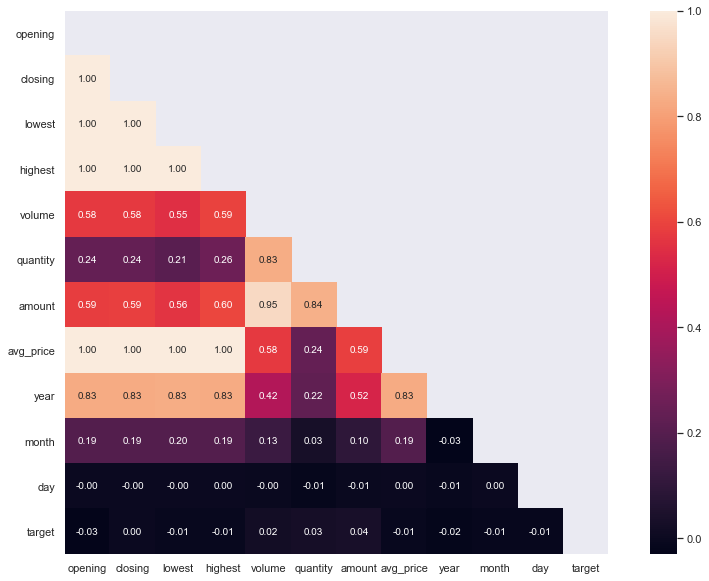

In [91]:
get_correlation(df_3)

### Excluindo colunas com alta correlação e que não influenciem na análise temporal

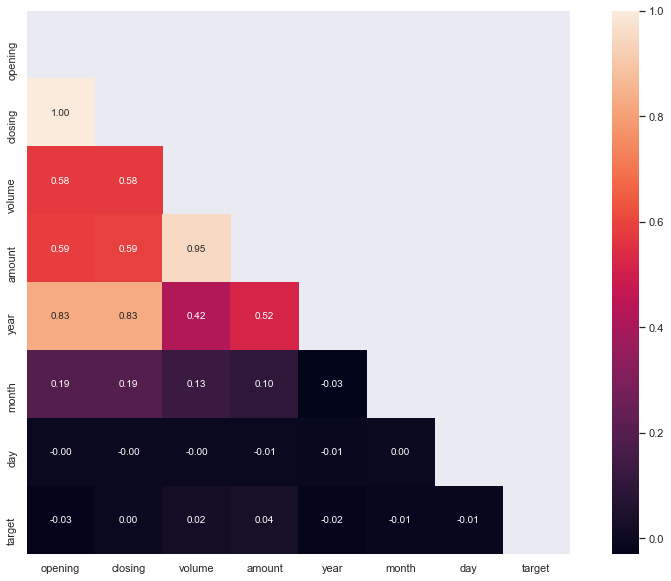

In [145]:
columns_to_remove = ['lowest', 'highest', 'quantity', 'avg_price']
df_4 = df_3.drop(columns = columns_to_remove)
get_correlation(df_4)

### Carregando dados de BTC juntamente com os indices 

In [154]:
df_5 = get_data_from_db()
df_5 = break_data(df_5, 'date')
df_5.head()

btcopening  btcclosing  btcquantity  btcamount  daxopening  daxclosing  \
0   885.00000   921.84715    76.619064      219.0   23.260702   23.260702   
1   806.00001   788.00000    77.536312      196.0   22.982425   22.120028   
2   788.00002   869.96999    75.642620      277.0   22.120028   22.120028   
3   869.96999   894.37342   128.782582      364.0   22.120028   22.120028   
4   912.07042   905.98343   117.252409      326.0   22.617903   22.742373   

   daxlowest  daxhighest    djiopening    djiclosing     djilowest  \
0  23.260702   23.260702  17833.000000  17833.000000  17833.000000   
1  22.120028   22.982425  17501.699219  17501.699219  17501.699219   
2  22.120028   22.120028  17371.599609  17371.599609  17371.599609   
3  22.120028   22.120028  17584.500000  17584.500000  17584.500000   
4  22.617903   22.742373  17907.900391  17907.900391  17907.900391   

     djihighest    hsiopening    hsiclosing     hsilowest    hsihighest  year  \
0  17833.000000  23857.800781  23857.800781  23857.800781  23857.800781  2015   
1  17501.699219  23721.300781  23721.300781  23721.300781  23721.300781  2015   
2  17371.599609  23485.400391  23485.400391  23485.400391  23485.400391  2015   
3  17584.500000  23681.300781  23681.300781  23681.300781  23681.300781  2015   
4  17907.900391  23835.500000  23835.500000  23835.500000  23835.500000  2015   

   month  day  
0      1    2  
1      1    5  
2      1    6  
3      1    7  
4      1    8

In [155]:
get_correlation(df_5)

### Removendo colunas com alta correlação

In [156]:
columns_to_remove = ['lowest', 'highest', 'opening']
new_c_to_remove = []
for col in columns_to_remove:
    for stk in stock_array: 
        new_c_to_remove.append(f"{stk.lower()}{col}")
    for crypto in stock_array: 
        new_c_to_remove.append(f"{crypto.lower()}{col}")
df_6 = df_5.drop(columns = np.array(new_c_to_remove))


In [157]:
get_correlation(df_6)

In [174]:
df_closing = pd.DataFrame(columns = ['btc', 'dji', 'dax', 'hsi','year', 'month', 'day'])
df_closing['btc'] = df_6['btcclosing']
df_closing['dji'] = df_6['djiclosing']
df_closing['dax'] = df_6['daxclosing']
df_closing['hsi'] = df_6['hsiclosing']
df_closing['year'] = df_6['year']
df_closing['month'] = df_6['month']
df_closing['day'] = df_6['day']

In [201]:
get_correlation(df_closing)

In [175]:
df_closing.head()

btc           dji        dax           hsi  year  month  day
0  921.84715  17833.000000  23.260702  23857.800781  2015      1    2
1  788.00000  17501.699219  22.120028  23721.300781  2015      1    5
2  869.96999  17371.599609  22.120028  23485.400391  2015      1    6
3  894.37342  17584.500000  22.120028  23681.300781  2015      1    7
4  905.98343  17907.900391  22.742373  23835.500000  2015      1    8

In [209]:
plot_stock_closing(df_closing)

In [171]:
EDA(df_closing, True)

Amount_NaN  %_NaN    DType  Amount_Data  Amount_Unique  \
btc                     0    0.0  float64         1303           1282   
complete_date           0    0.0   object         1303              1   
dax                     0    0.0  float64         1303           1167   
day                     0    0.0    int64         1303             31   
dji                     0    0.0  float64         1303           1293   
hsi                     0    0.0  float64         1303            904   
month                   0    0.0    int64         1303             12   
year                    0    0.0    int64         1303              6   

                   Mean    Median  \
btc            18635.53  11180.00   
complete_date       NaN       NaN   
dax               25.04     24.74   
day               15.83     16.00   
dji            21877.25  21636.80   
hsi            16380.43  22885.90   
month              6.26      6.00   
year            2017.24   2017.00   

                                                             Max  \
btc                                                       103953   
complete_date  0       2015\n1       2015\n2       2015\n3   ...   
dax                                                      31.5838   
day                                                           31   
dji                                                      30218.3   
hsi                                                      33154.1   
month                                                         12   
year                                                        2020   

                                                             Min       STD  
btc                                                          550  20963.00  
complete_date  0       2015\n1       2015\n2       2015\n3   ...       NaN  
dax                                                      17.1868      2.86  
day                                                            1      8.72  
dji                                                      15660.2   3805.65  
hsi                                                        0.065  12030.33  
month                                                          1      3.38  
year                                                        2015      1.68

In [223]:
df_closing_log = np.log(df_closing)
EDA(df_closing_log, True)

Amount_NaN  %_NaN    DType  Amount_Data  Amount_Unique  Mean  Median  \
btc             0    0.0  float64         1303           1282  8.93    9.32   
dji             0    0.0  float64         1303           1167  9.98    9.98   
dax             0    0.0  float64         1303             31  3.21    3.21   
hsi             0    0.0  float64         1303           1293  5.96   10.04   
year            0    0.0  float64         1303            904  7.61    7.61   
month           0    0.0  float64         1303             12  1.63    1.79   
day             0    0.0  float64         1303              6  2.52    2.77   

             Max       Min   STD  
btc    11.551697  6.309918  1.53  
dji    10.316203  9.658878  0.17  
dax     3.452643  2.844144  0.11  
hsi    10.408922 -2.733368  5.82  
year    7.610853  7.608374  0.00  
month   2.484907  0.000000  0.71  
day     3.433987  0.000000  0.81

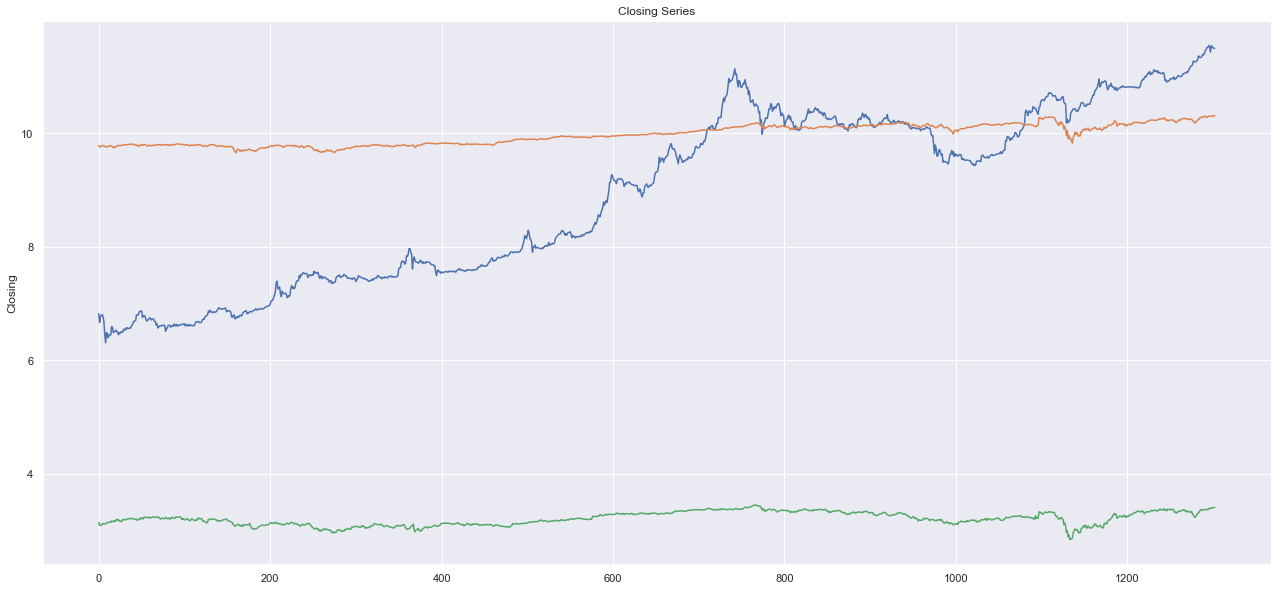

In [224]:
plot_stock_closing(df_closing_log)

In [221]:
df_closing_scaler = pd.DataFrame(StandardScaler().fit(df_closing).fit_transform(df_closing), columns = df_closing.columns)
df_closing_scaler = df_closing_scaler.drop(columns = ['year', 'month', 'day'])
df_closing_scaler.head()

btc       dji       dax       hsi
0 -0.845322 -1.063106 -0.622808  0.621782
1 -0.851709 -1.150195 -1.022482  0.610431
2 -0.847797 -1.184394 -1.022482  0.590815
3 -0.846633 -1.128429 -1.022482  0.607105
4 -0.846079 -1.043417 -0.804422  0.619927

In [222]:
plot_stock_closing(df_closing_scaler)

In [234]:
display(df_closing.btc.describe())
sns.distplot(df_closing.btc, hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

count      1303.000000
mean      18635.531823
std       20963.004924
min         550.000000
25%        1799.950000
50%       11179.999810
75%       28994.469990
max      103953.339050
Name: btc, dtype: float64

In [235]:
display(df_closing.dji.describe())
sns.distplot(df_closing.dji, hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})



count     1303.000000
mean     21877.254425
std       3805.647775
min      15660.200195
25%      18032.300781
50%      21636.800781
75%      25200.799805
max      30218.300781
Name: dji, dtype: float64

count    1303.000000
mean       25.038203
std         2.855107
min        17.186836
25%        22.637233
50%        24.742781
75%        27.556014
max        31.583763
Name: dax, dtype: float64

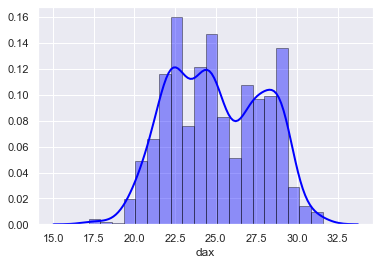

In [236]:
sns.distplot(df_closing.dax, hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
display(df_closing.dax.describe())

In [237]:
sns.distplot(df_closing.hsi, hist=True, kde=True,
             bins=20,              
             color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
display(df_closing.hsi.describe())

count     1303.000000
mean     16380.431230
std      12030.333088
min          0.065000
25%          0.175000
50%      22885.900391
75%      25278.399414
max      33154.101562
Name: hsi, dtype: float64

### Lag Features